# 4.4

Load imdb dataset

In [2]:
from keras.datasets import imdb
import numpy as np
import textwrap
import matplotlib.pyplot as plt

# Load IMDB dataset.
# Only 1e4 most frequent woeds are kept. They are represented as intagers.
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=1e4)

def decode_review(index):
# display with: print(f"Decoded {'positive' if label else 'negative'} review:\n{textwrap.fill(decoded_review)}")

    word_index = imdb.get_word_index()
    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

    # Start from 3 because first 3 numbers are reserved, if word is not in dict put default '?' char.
    decoded_review = ' '.join([reverse_word_index.get(word - 3, '?') for word in
                               train_data[index]])
    return decoded_review

# Question: Could we count the number of words instead?
def vectorize_sequences(sequences, dimension=int(1e4)):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results


# Vectorize sequences
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

# Vectorize labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

# Training and validation datasets.
x_val = x_train[:int(1e4)]
partial_x_train = x_train[int(1e4):]
y_val = y_train[:int(1e4)]
partial_y_train = y_train[int(1e4):]

Create model. test larger and smaller size.

In [13]:
from keras import models
from keras import layers
from keras import optimizers
def train_network(size):
    model = models.Sequential()
    model.add(layers.Dense(size, activation='relu', input_shape=(int(1e4),)))
    model.add(layers.Dense(size, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizers.RMSprop(lr=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Train the model for 20 epochs with 512 batch size.
    history = model.fit(partial_x_train,
                                 partial_y_train,
                                 epochs=15,
                                 batch_size=512,
                                 validation_data=(x_val, y_val),
                                 verbose=0)
    # Test results.
    results_test = model.evaluate(x_test, y_test, verbose=0)
    results_train = model.evaluate(partial_x_train, partial_y_train, verbose=0)
    results_validate = model.evaluate(x_val, y_val,verbose=0)
    print(f"[TRAIN, VALIDATE, TEST]:"
          f"[{results_train[1]*100:.2f}, {results_validate[1]*100:.2f}, {results_test[1]*100:.2f}]")
    return history


In [14]:
print("Original network:")
original_history=train_network(16)
print("Small network:")
small_history=train_network(4)
print("Large network:")
large_history=train_network(512)

Original network:
[TRAIN, VALIDATE, TEST]:[99.94, 87.15, 85.71]
Small network:
[TRAIN, VALIDATE, TEST]:[98.66, 88.22, 87.03]
Large network:
[TRAIN, VALIDATE, TEST]:[100.00, 88.42, 87.37]


In [35]:
def plot_val_history(history, *args, **kwargs):
    val_loss_values = history.history['val_loss']
    epochs = range(1, len(val_loss_values) + 1)
    plt.plot(epochs, val_loss_values, *args, **kwargs)
    
def plot_train_history(history, *args, **kwargs):
    val_loss_values = history.history['loss']
    epochs = range(1, len(val_loss_values) + 1)
    plt.plot(epochs, val_loss_values, *args, **kwargs)
    
def plot_val_acc_history(history, *args, **kwargs):
    val_loss_values = history.history['val_acc']
    epochs = range(1, len(val_loss_values) + 1)
    plt.plot(epochs, val_loss_values, *args, **kwargs)

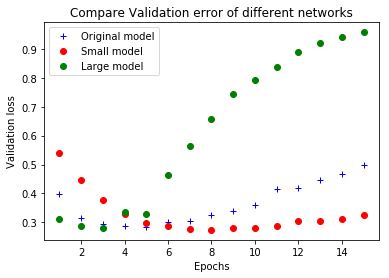

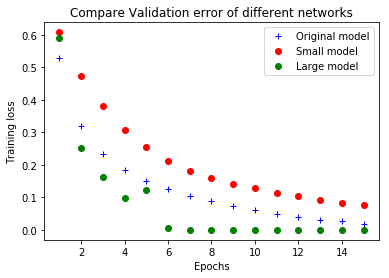

In [30]:
# Plot validation history.
plt.figure()
plot_val_history(original_history, 'b+', label='Original model')
plot_val_history(small_history,    'ro', label='Small model')
plot_val_history(large_history,    'go', label='Large model')
plt.title('Compare Validation error of different networks')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

# Plot training history.
plt.figure()
plot_train_history(original_history, 'b+', label='Original model')
plot_train_history(small_history,    'ro', label='Small model')
plot_train_history(large_history,    'go', label='Large model')
plt.title('Compare Validation error of different networks')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend()


We can se that the large model lowers the traing loss to zero quickly but it's validation loss starts quickly developing very high overfitting. Where as the small model struggles with training loss but does not overfit nearly as moch as the other two.

## Regulizers
### L1 and L2
Two kinds of regularization are explored here: L1 and L2. L1 adds cost proportianal to the absoulute value of the used coefficents (L1 norm) and L2 adds cost proportial to the squre of the weigts(L2 norm). 

They can be added by passing a *weight regulizer instance* to the layers.

**NOTE**: becuse regulizers add penalties during training loss will be lower during evaluation.

In [37]:
from keras import regularizers
# Add L2 regulizer.
model = models.Sequential()
model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(1e-3), activation='relu', input_shape=(int(1e4),)))
model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(1e-3), activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model for 20 epochs with 512 batch size.
L2_history = model.fit(partial_x_train,
                             partial_y_train,
                             epochs=15,
                             batch_size=512,
                             validation_data=(x_val, y_val),
                             verbose=0)
# Test results.
results_test = model.evaluate(x_test, y_test, verbose=0)
results_train = model.evaluate(partial_x_train, partial_y_train, verbose=0)
results_validate = model.evaluate(x_val, y_val,verbose=0)
print(f"[TRAIN, VALIDATE, TEST]:"
      f"[{results_train[1]*100:.2f}, {results_validate[1]*100:.2f}, {results_test[1]*100:.2f}]")

[TRAIN, VALIDATE, TEST]:[98.75, 87.52, 86.52]


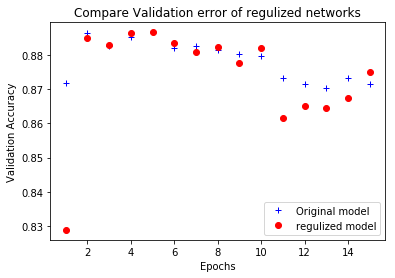

In [38]:
# Plot validation accuracy history.
plt.figure()
plot_val_acc_history(original_history, 'b+', label='Original model')
plot_val_acc_history(L2_history,       'ro', label='regulized model')
plt.title('Compare Validation error of regulized networks')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()

### Dropout
Dropout randomly "drops out" (sets to zero) output features of the layer during training. It is set as a fraction of the features (usualy 0.2-0.5).

At test time no values are droped the values are scaled down by a factor equal to the dropout factor to offset more units being active.

In [39]:
from keras import regularizers
# Add Dropout layers regulizer.
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(int(1e4),)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model for 20 epochs with 512 batch size.
dropout_history = model.fit(partial_x_train,
                             partial_y_train,
                             epochs=15,
                             batch_size=512,
                             validation_data=(x_val, y_val),
                             verbose=0)
# Test results.
results_test = model.evaluate(x_test, y_test, verbose=0)
results_train = model.evaluate(partial_x_train, partial_y_train, verbose=0)
results_validate = model.evaluate(x_val, y_val,verbose=0)
print(f"[TRAIN, VALIDATE, TEST]:"
      f"[{results_train[1]*100:.2f}, {results_validate[1]*100:.2f}, {results_test[1]*100:.2f}]")

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
[TRAIN, VALIDATE, TEST]:[98.61, 88.33, 87.30]


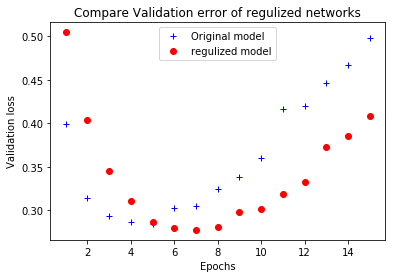

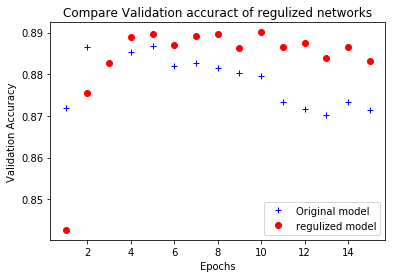

In [41]:
# Plot validation loss history.
plt.figure()
plot_val_history(original_history, 'b+', label='Original model')
plot_val_history(dropout_history,       'ro', label='regulized model')
plt.title('Compare Validation error of regulized networks')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

# Plot validation accuracy history.
plt.figure()
plot_val_acc_history(original_history, 'b+', label='Original model')
plot_val_acc_history(dropout_history,       'ro', label='regulized model')
plt.title('Compare Validation accuract of regulized networks')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()